# Import

In [1]:
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import math
import random

In [2]:
plm_url = "E:/[1]ASS_Data/junyi/junyi_Exercise_table.csv" #[change to your own path]
logs_url = "E:/[1]ASS_Data/junyi/junyi_ProblemLog_original/junyi_ProblemLog_original.csv" #[change to your own path]

# Read data

## R1-1: read_ Exercise_table

In [3]:
plm_df = pd.read_csv(plm_url) #shape:(837, 11)

In [4]:
select_collumns = ['name','topic','area']
plm_s_df = plm_df[select_collumns]
#plm_s_df.head()
plm_s_df.shape #:(837, 3)
#plm_s_df.isnull().sum() name:0 topic:20

(837, 3)

In [5]:
# drop_duplicates
plm_s_df = plm_s_df.drop_duplicates().reset_index(drop=True)
plm_s_df = plm_s_df.reset_index(drop=True)
plm_s_df.shape #：(835, 3)

(835, 3)

In [6]:
# plm_SKname_dic
plm_SKname_dic = plm_s_df.set_index('name')['topic'].to_dict()
#len(plm_SKname_dic)#: 835

In [7]:
lost_topics_names = plm_s_df[plm_s_df.isnull().any(axis = 1) == True]['name'].tolist()
lost_map = {}
for index, value in enumerate(lost_topics_names):
    lost_map[value] = 'unknown_topic_' + str(index)

In [8]:
for key, value in lost_map.items():
    plm_SKname_dic[key] = value

In [9]:
plm_s_df['topic'] = plm_s_df['name'].map(plm_SKname_dic)
plm_s_df.head()

,name,topic,area
0,parabola_intuition_1,conic-sections,algebra
1,circles_and_arcs,area-perimeter-and-volume,geometry
2,inscribed_angles_3,circle-properties,geometry
3,solving_quadratics_by_factoring,quadtratics,algebra
4,graphing_parabolas_1,quadtratics,algebra


In [10]:
plm_s_df['area'].fillna('unknown_area', inplace=True)

## R2: read_ Logs

In [11]:
logs_df = pd.read_csv(logs_url) #shape:(25925992, 17)

In [12]:
select_columns = ['user_id', 'exercise', 'correct', 'time_done', 'problem_number']
logs_s_df = logs_df[select_columns]
del(logs_df)
logs_s_df.head()
#logs_s_df.shape #:(25925992, 5)

,user_id,exercise,correct,time_done,problem_number
0,12884,time_terminology,False,1420714810324490,1
1,239464,multiplication_1,True,1403098400836660,6
2,147359,adding_decimals_0.5,True,1418890695540340,6
3,158155,multiplication_1,True,1400469444264040,3
4,147151,subtraction_2,True,1382650905730160,10


In [13]:
logs_s_df_copy = logs_s_df.copy()
logs_s_df_copy.dropna(inplace=True)
logs_s_df = logs_s_df_copy 
#logs_s_df.shape #shape: (25925992, 5)

In [14]:
logs_s_df = logs_s_df.drop_duplicates().reset_index(drop=True)
#logs_s_df.shape #：(25924553, 5)

# 1 Remove

## 1-1 Remove students whose answers are less than or equal to 14 times

In [15]:
stu_list = logs_s_df['user_id'].value_counts().index.tolist()
#len(stu_list) #:247606

In [16]:
stu_times = logs_s_df['user_id'].value_counts()
rare_stu = stu_times[stu_times <= 14].index.tolist()
#len(rare_stu) #:135837

In [17]:
logs_s_df = logs_s_df[~logs_s_df['user_id'].isin(rare_stu)]
logs_s_df = logs_s_df.reset_index(drop=True)
#logs_s_df.shape #：(25265344, 5)

## 1-2 Remove questions answered less than or equal to 2 times

In [18]:
exer_list = logs_s_df['exercise'].value_counts().index.tolist()
len(exer_list) #:722

722

In [19]:
exer_times = logs_s_df['exercise'].value_counts()
rare_exer = exer_times[exer_times <= 2].index.tolist()
len(rare_exer) #:4

4

In [20]:
logs_s_df = logs_s_df[~logs_s_df['exercise'].isin(rare_exer)]
logs_s_df = logs_s_df.reset_index(drop=True)
logs_s_df.shape #：(25265339, 5)

(25265339, 5)

# 2 Randomly select 5000 students

In [21]:
stu_list = logs_s_df['user_id'].value_counts().index.tolist()
random_seed = 42
random.seed(random_seed)
selected_students = random.sample(stu_list, 5000)

In [22]:
filtered_df = logs_s_df[logs_s_df['user_id'].isin(selected_students)]
del(logs_s_df)
filtered_df.head()
#filtered_df.shape #:(1049003, 5)

,user_id,exercise,correct,time_done,problem_number
0,12884,time_terminology,False,1420714810324490,1
1,239464,multiplication_1,True,1403098400836660,6
22,210091,combining_like_terms_1,True,1418635984961280,39
53,240639,volume_of_rectangular_boxes,False,1406297834969390,2
128,129105,divisibility_intuition,True,1393835171845250,4


In [23]:
# Group by' user_id' and sort by' time_done' within each group.
filtered_df_sorted = filtered_df.groupby('user_id').apply(lambda x: x.sort_values('time_done')).reset_index(drop=True)
filtered_df_sorted.head() #shape #：(337998, 5)

,user_id,exercise,correct,time_done,problem_number
0,9,representing_numbers,True,1403592558383180,1
1,9,representing_numbers,False,1403592603171810,2
2,9,representing_numbers,True,1403592649235970,3
3,9,representing_numbers,True,1403592661733850,4
4,9,representing_numbers,True,1403592669308810,5


In [24]:
filtered_df_sorted['skill'] = filtered_df_sorted['exercise'].map(plm_SKname_dic)

In [25]:
filtered_df_sorted.head(5)

,user_id,exercise,correct,time_done,problem_number,skill
0,9,representing_numbers,True,1403592558383180,1,addition-subtraction
1,9,representing_numbers,False,1403592603171810,2,addition-subtraction
2,9,representing_numbers,True,1403592649235970,3,addition-subtraction
3,9,representing_numbers,True,1403592661733850,4,addition-subtraction
4,9,representing_numbers,True,1403592669308810,5,addition-subtraction


# 3 Obtain all dic

In [26]:
stu_list = filtered_df_sorted['user_id'].value_counts().index.tolist()
#len(stu_list)#: 5000
problem_list = filtered_df_sorted['exercise'].value_counts().index.tolist()
#len(problem_list)#: 683
kc_list = filtered_df_sorted['skill'].value_counts().index.tolist() 
#len(kc_list)#: 40

In [27]:
stu_get_ID = {}
plm_get_ID = {}
kc_get_ID = {}

stu_get_oriID = {}
plm_get_NAME = {}
kc_get_NAME = {}

In [28]:
for index,value in enumerate(stu_list):
    stu_get_ID[value] = index
    stu_get_oriID[index] = value
for index,value in enumerate(problem_list):
    plm_get_ID[value] = index
    plm_get_NAME[index] = value
for index,value in enumerate(kc_list):
    kc_get_ID[value] = index
    kc_get_NAME[index] = value

In [29]:
with open('jun_stu_get_ID.json', 'w', encoding='utf-8') as f:
    json.dump(stu_get_ID, f, ensure_ascii=False, indent=4)
with open('jun_plm_get_ID.json', 'w', encoding='utf-8') as f:
    json.dump(plm_get_ID, f, ensure_ascii=False, indent=4)
with open('jun_kc_get_ID.json', 'w', encoding='utf-8') as f:
    json.dump(kc_get_ID, f, ensure_ascii=False, indent=4)

In [31]:
# user_id   problem_id   skill_id   correct
mapping_df = filtered_df_sorted.copy() 
mapping_df['user_id'] = filtered_df_sorted['user_id'].map(stu_get_ID)
mapping_df['exercise'] = filtered_df_sorted['exercise'].map(plm_get_ID)
mapping_df['skill'] = filtered_df_sorted['skill'].map(kc_get_ID)
mapping_df['correct'] = filtered_df_sorted['correct'].astype(int)

In [32]:
mapping_df.loc[mapping_df['user_id'] == 0]

,user_id,exercise,correct,time_done,problem_number,skill
785646,0,38,0,1379484348679390,1,8
785647,0,146,1,1379484643393610,1,8
785648,0,146,0,1379484829683670,2,8
785649,0,239,0,1379641907911920,1,8
785650,0,239,1,1379641942981680,2,8
...,...,...,...,...,...,...
793511,0,142,1,1399985182808440,40,8
793512,0,142,1,1399985196715120,41,8
793513,0,142,0,1399985212310680,42,8
793514,0,142,1,1399985244099550,43,8


# 4 Generate JSON file

In [33]:
problem_skill_group_dic = {}
problem_list = mapping_df['exercise'].value_counts().index.tolist()
for index, p_id in enumerate(problem_list):
    p_float_list = mapping_df.loc[mapping_df['exercise'] == p_id]['skill'].value_counts().index.tolist()
    p_int_list = list(map(int, p_float_list))
    problem_skill_group_dic[p_id] = p_int_list
def save_dict_to_txt(dictionary, filename):
    with open(filename, 'w', encoding='utf-8') as file:
        json.dump(dictionary, file, ensure_ascii=False, indent=4)
# Save txt
save_dict_to_txt(problem_skill_group_dic, 'junyi_q_kc_dic.txt')

In [30]:
# user_id   exercise   correct   time_done   problem_number   skill

In [31]:
#生成JSON文件
initial_json_list = []
Response_records_all_students = []

for stu_id in stu_get_oriID:
    df_1 = mapping_df.loc[mapping_df['user_id'] == stu_id]
    logs_list = []
    logs_num = len(df_1);
    for index, row in df_1.iterrows():
        p_id = row['exercise']
        p_code = [row['skill']]
        if len(p_code) >= 1:
            logs_item = {"exer_id": p_id, "score": row['correct'], "knowledge_code": p_code}
            logs_list.append(logs_item)
    initial_json_item = {
        "stu_id": stu_id,
        "log_num": len(logs_list),
        "logs":logs_list
    }
    Response_records_all_students.append(len(logs_list))
    initial_json_list.append(initial_json_item)

In [32]:
# Overview of student records
Response_records = sum(Response_records_all_students)
Response_records_per_students = Response_records / len(Response_records_all_students)
print("Response_records:", Response_records)
print("Response_records_per_students:", Response_records_per_students)

Response_records: 1049003
Response_records_per_students: 209.8006


In [33]:
# Save JSON file 
def convert_int64_to_int(obj):
    if isinstance(obj, np.int64):
        return int(obj)
    raise TypeError
initial_json = json.dumps(initial_json_list, default=convert_int64_to_int, ensure_ascii=False, indent=4, separators=(',', ': '))
filename = 'C:/Users/Lenovo/Desktop/Junyi5000_s15_p2_logs.json'
with open(filename, 'w', encoding='utf-8') as file:
    file.write(initial_json)

# 5 Generate knowledge graph

## 5-1 SentenceTransformer -> semantic similarity

In [34]:
#plm_SKname_dic
# stu_get_ID
# plm_get_ID
# kc_get_ID

# stu_get_oriID
# plm_get_NAME
# kc_get_NAME

In [35]:
model = SentenceTransformer('E:/[model]big_model/all-MiniLM-L6-v2')

In [36]:
# kcid-kc_tensor
KCID_tensor_dic = {}
for kcid in kc_get_NAME:
    embedding = model.encode(kc_get_NAME[kcid], convert_to_tensor=True)
    KCID_tensor_dic[kcid] = embedding

In [37]:
# Similarity matrix
mx_size = len(kc_get_NAME)
s_matrix = np.zeros((mx_size, mx_size))

for kcid1 in KCID_tensor_dic:
    t1 = KCID_tensor_dic[kcid1]
    for kcid2 in KCID_tensor_dic:
        if(kcid1 == kcid2):
            s_matrix[kcid1][kcid2] = 0
            continue
        t2 = KCID_tensor_dic[kcid2]
        s_matrix[kcid1][kcid2] = util.pytorch_cos_sim(t1, t2)

<Axes: >

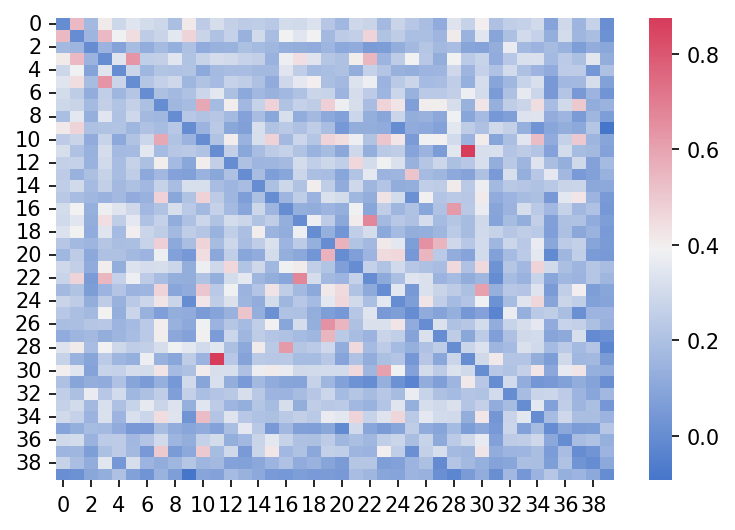

In [38]:
# Heat map analysis
plt.figure(dpi=150, figsize=(6, 4))
sns.heatmap(
    data=s_matrix,
    cmap=sns.diverging_palette(255, 5, as_cmap=True),
)
#plt.savefig('skill_heatmap_before.png')

In [39]:
# Generating similarity binary group
s_triple_list = []
for i in range(mx_size):
    for j in range(mx_size):
        if s_matrix[i][j] > 0.4:
            triple_item = [i,j]
            s_triple_list.append(triple_item)
            triple_item = [j,i]
            s_triple_list.append(triple_item)
len(s_triple_list) #:248

248

In [40]:
s_triple_df = pd.DataFrame(s_triple_list, columns=['Subject','Object'])

## Analysis of Co-occurrence of Knowledge Points

In [47]:
select_columns = ['topic', 'area']
kc_area_df = plm_s_df[select_columns]
kc_area_df = kc_area_df.drop_duplicates().reset_index(drop=True)
kc_area_df.head()
#kc_area_df.shape #:(59, 2)
# len(area) : 9

,topic,area
0,conic-sections,algebra
1,area-perimeter-and-volume,geometry
2,circle-properties,geometry
3,quadtratics,algebra
4,algebra-functions,algebra


In [52]:
# SKname_AREA_dic
SKname_AREA_dic = kc_area_df.set_index('topic')['area'].to_dict()
#len(SKname_AREA_dic) #:59

In [56]:
NOW_SKname_AREA_dic = {}
for now_kc in kc_list:
    NOW_SKname_AREA_dic[now_kc] = SKname_AREA_dic[now_kc]
#len(NOW_SKname_AREA_dic) #:40

40

In [60]:
coo_dict = {}
for key, value in NOW_SKname_AREA_dic.items():
    if value not in coo_dict:
        coo_dict[value] = []
    coo_dict[value].append(key)
    
coo_list = list(coo_dict.values())
#len(coo_list) #:9

In [67]:
skill_id_coo_list = []
for skill_group in coo_list:
    skill_id_group = [kc_get_ID[skill_name] for skill_name in skill_group]
    skill_id_coo_list.append(skill_id_group)
#len(skill_id_coo_list) #:9

9

In [70]:
# Co-occurrence matrix
mx_size = len(kc_get_NAME)
coo_matrix = np.zeros((mx_size, mx_size))
for r_p_group in skill_id_coo_list:
    for i in range(0,len(r_p_group)):
        for j in range(i+1,len(r_p_group)):
            coo_matrix[r_p_group[i],r_p_group[j]] += 1;
            coo_matrix[r_p_group[j],r_p_group[i]] += 1;

<Axes: >

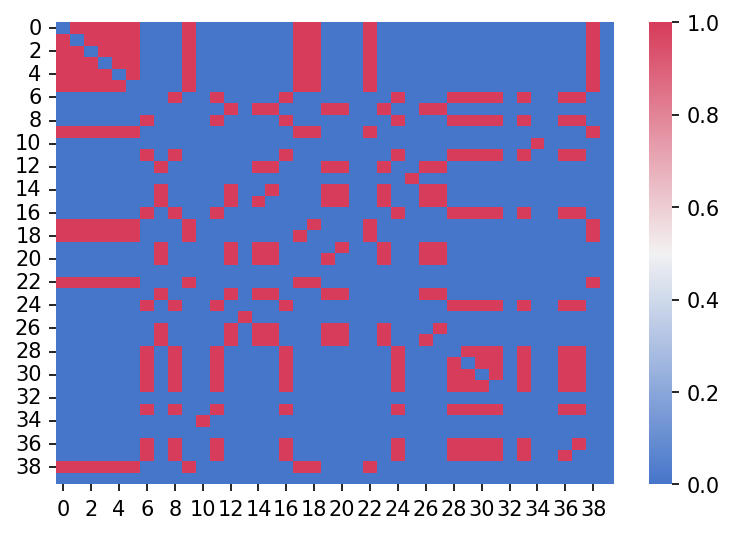

In [71]:
# Heat map analysis
plt.figure(dpi=150, figsize=(6, 4))
sns.heatmap(
    data=coo_matrix,
    cmap=sns.diverging_palette(255, 5, as_cmap=True),
)

In [72]:
# Generating binary group
m_triple_list = []
for i in range(mx_size):
    for j in range(mx_size):
        if coo_matrix[i][j] > 0:
            triple_item = [i,j]
            m_triple_list.append(triple_item)
            triple_item = [j,i]
            m_triple_list.append(triple_item)
len(m_triple_list) #:636

636

In [73]:
# Generating binary group
m_triple_df = pd.DataFrame(m_triple_list, columns=['Subject','Object'])

## 5-3 Knowledge graph file

In [74]:
# s_triple_df
# m_triple_df
# 'Subject','Object'

In [75]:
kg_df = pd.concat([s_triple_df, s_triple_df], ignore_index=True)
kg_df = kg_df.drop_duplicates()
kg_df.head(3)
#kg_df.shape #:(124, 2)

(124, 2)

In [76]:
# Save
kg_df.to_csv('C:/Users/Lenovo/Desktop/Junyi5000_s15_p2_graph.txt', sep='\t', index=False, header=False) #[change to your own path]